In [1]:
# Imports

import bmi
import bmi.wrapper
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive, Layout, interact
import numpy as np
import logging
import threading
import time

# Something very fishy happening if I don't define a plot first.
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()
_ = plt.figure()
plt.ion()

In [2]:
engine = r'C:\Users\vries_cy\OneDrive - Stichting Deltares\Desktop\DFM-old\share\bin\dflowfm'
wrapper = bmi.wrapper.BMIWrapper(engine=engine);
engine = r'C:\Users\vries_cy\OneDrive - Stichting Deltares\Desktop\DFM\x64\dflowfm\bin\dflowfm'
mdufile = r'C:\Users\vries_cy\PAOTM cursus\c081_flow_over_subgrid_groyne\groyne01_Q-H.mdu'

In [3]:
data = []
items = []
wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
wrapper.initialize()

In [4]:
for i in range(wrapper.get_var_count()):
    print(wrapper.get_var_name(i), wrapper.get_var_shape(wrapper.get_var_name(i)))

b'DFM_COMM_DFMWORLD' ()
b'iglobal_s' (4392,)
b'hwav' (4392,)
b'twav' (4392,)
b'Uorb' (4392,)
b'infilt' (4392,)
b'infiltcap' (4392,)
b'shx' (0,)
b'shy' (0,)
b'shi' (0,)
b'zsp' (4392,)
b'zsp0' (4392,)
b'zspc' (4477,)
b'zspc0' (4477,)
b'v0ship' (4392,)
b'v1ship' (4392,)
b'qinship' (4392,)
b'vicushp' (8556,)
b'shL' (2,)
b'shB' (2,)
b'shd' (2,)
b'stuw' (2,)
b'fstuw' (2,)
b'stuwmx' (2,)
b'roer' (2,)
b'froer' (2,)
b'roermx' (2,)
b'wx' (8556,)
b'wy' (8556,)
b'wmag' (8556,)
b'rain' (4392,)
b'evap' (4392,)
b'numlatsg' ()
b'qplat' (0,)
b'qqlat' (4392,)
b'balat' (0,)
b'nnlat' (4392,)
b'qinext' (4392,)
b'qinextreal' (4392,)
b'vincum' (4392,)
b'zbndz' (72,)
b'zbndu' (0,)
b'zbndq' (0,)
b'rnveg' (4392,)
b'diaveg' (4392,)
b'cfuveg' (8556,)
b'alfaveg' (8556,)
b'stemdens' (4392,)
b'stemdiam' (4392,)
b'stemheight' (4392,)
b'zws' (4392,)
b'kbot' (4392,)
b'ktop' (4392,)
b'Lbot' (8556,)
b'Ltop' (8556,)
b's0' (4392,)
b's1' (4392,)
b'a0' (4392,)
b'a1' (4392,)
b'vol0' (4392,)
b'vol1' (4392,)
b'vol1_f' (4392,)
b

In [5]:
# Create widgets

run = widgets.Button(
    description='Run Model',
    button_style='',
    tooltip='Description',
    icon='play'
)

stop = widgets.Button(
    description='Stop Model',
    button_style='',
    tooltip='Description',
    icon='stop',
    disabled=True
)

update = widgets.Button(
    description='Single update',
    button_style='',
    tooltip='Update with 1 timestep',
    icon='step-forward'
)
restart = widgets.Button(
    description='Restart model',
    button_style='',
    tooltip='Restart entire model with initial inputs',
    icon='retweet'
)

settings = widgets.HTML(
    value="Welcome!",
    placeholder='Input settings'
)

play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=int(wrapper.get_end_time()),
    step=1,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider(    min=0,
    max=int(wrapper.get_end_time()))
widgets.jslink((play, 'value'), (slider, 'value'))
player = widgets.HBox([play, slider])

parameters = ["zbndz", "zbndz"]
p_descrip = ["Boundary Water level Downstream", "Boundary Water level Upstream"]
style = {'description_width': 'initial'}

for p in range(len(parameters)): 
    items.append(widgets.Text(
        description=p_descrip[p],
        disabled=False,
        value=str(wrapper.get_var(parameters[p])[0]),
        placeholder=str(parameters[p]),
        style=style,
        layout=Layout(width='50vw')
    ))

In [6]:
wrapper.get_end_time()

1800.0

In [19]:
# Model specific function 

#     Automate parameter and grid sizes
def update_data():
    ucx = wrapper.get_var('ucx')[:]
    ucy = wrapper.get_var('ucy')[:]
    xz = wrapper.get_var('xz')[:]
    yz = wrapper.get_var('yz')[:]

    data.append(dict({
        "time": wrapper.get_current_time(),
        "veloX": ucx, 
        "veloY": ucy, 
        "xz": xz, 
        "yz": yz,
        "mag": np.sqrt(ucx**2 + ucy**2)
    }))
    settings.value = "Model update, timestep: {}".format(data[-1]["time"])
update_data()


In [20]:
# Standard functions for button widgets

dostop = False

def update_model(b=None):
#     Update the model with t = 1
    wrapper.update(1.0)
    if(data[-1]["time"] != wrapper.get_current_time()):
        update_data()

def start_loop(n):
#     Start the loop for running the model continuously
#     while run.value == True: 
    for i in range(n):
        print(i, wrapper.get_current_time())
        update_model()
        if (wrapper.get_current_time() >= wrapper.get_end_time()):
            stop.disabled = True
            run.disabled = True
            break
        if dostop == True: 
            break
#         time.sleep(1.0)


def run_model(change): 
#     When the run/stop model button is pressed either start the model loop or stop it
    stop.disabled = False
    run.disabled = True
    update.disabled = True
    for i in items:
        i.disabled = True
    start_loop(4)
    print('stop')
#         thread = threading.Thread(target=start_loop)
#         thread.start()

def stop_model(change):
    update.disabled = True
    run.disabled = False
    stop.disabled = True
    for i in items:
        i.disabled = False
    dostop = True

def change_param(v):
#     set parameters in model
    old_par = wrapper.get_var(v.placeholder)
    new_par = np.ones_like(old_par) * float(v.value)
    if (v.description == "Boundary Water level Downstream"): 
        new_par[:36] = float(v.value)
    if (v.description == "Boundary Water level Upstream"): 
        new_par[36:] = float(v.value)
    wrapper.set_var(v.placeholder, new_par)
    settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])

def start_model():
#     start model
    wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
    wrapper.initialize()
    update_data()
    for i in range(len(items)): 
        items[i].value = str(wrapper.get_var(parameters[i])[0])
        
def restart_model(b=None):
#     stop the model and call function to restart the model
    del data[:]
    wrapper.finalize()
    start_model()
    settings.value = "Restarting model"

<IPython.core.display.Javascript object>


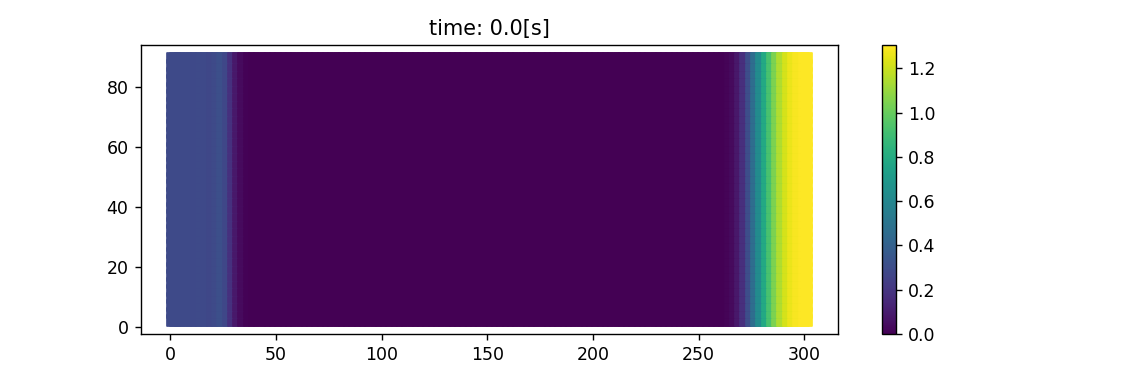

In [37]:
# set plot size
plt.rcParams["figure.figsize"] = (9, 3) # (w, h)

# link functions to widgets
run.on_click(run_model)
stop.on_click(stop_model)
update.on_click(update_model)
restart.on_click(restart_model)

def set_plot(change):
    t = change['new']
    print(t)
    settings.value = t

    if (t < len(data)):
        vortscat.set_array(data[1]["veloX"])
#         wlp.set_data(data[t]["xz"], data[t]["waterlevel"])
#         blp.set_data(data[t]["xz"], data[t]["bedlevel"])
#         wh.set_data(data[t]["xz"], data[t]["energyhead"])
        plt.title("time: " + str(data[t]["time"]) + "[s]")
#         fig1.canvas.draw()
        
player.children[-1].observe(set_plot, 'value')

controls = HBox([run, stop, update, restart])
params = VBox(items)

for i in items: 
    i.on_submit(change_param)

display(VBox([settings, controls, HBox([params]), player]))
plt.figure()
vortscat = plt.scatter(data[0]["xz"], data[0]["yz"], marker="s",  c=data[0]["veloX"], )
# blp, = ax1.plot(data[0]["xz"], data[0]["bedlevel"], color="black", label="bed level") 
# ax1.set_ylim(0, 2.5)
# ax1.grid()
# ax1.legend()
plt.title("time: " + str(data[0]["time"]) + "[s]")
# wh, = ax2.plot(data[0]["xz"], data[0]["energyhead"],'.')
# ax2.set_ylim(1, 3)

plt.colorbar(vortscat)


2

<IPython.core.display.Javascript object>


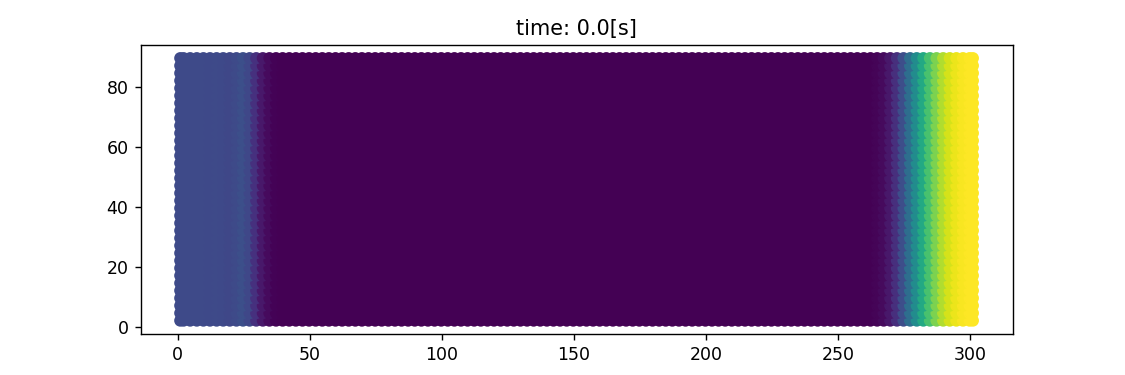

In [34]:
plt.figure()
vortscat = plt.scatter(data[0]["xz"], data[0]["yz"])
plt.title("time: " + str(data[0]["time"]) + "[s]")
vortscat.set_array(data[1]["veloX"])